# Support Vector Machine

## Importing SVM problem solver and datasets

In [1]:
from SupportVectorMachine import support_vector_machine
import numpy as np

def load_data_set(data_set_name: str):
    print("loading %s" % data_set_name)
    data = np.genfromtxt("datasets/%s.csv" % data_set_name, dtype=None, delimiter=',', names=True)
    print("columns", data.dtype.names)

    objects = np.array([np.array(i.tolist())[:-1] for i in data], dtype=float)
    classes = np.array([i[data.dtype.names.index('class')] for i in data])
    new_classes = np.array([], dtype=int)
    
    classes_dictionary = {}
    for i in classes:
        if i not in classes_dictionary:
            classes_dictionary[i] = (len(classes_dictionary) + 1) * 2 - 3
        new_classes = np.append(new_classes, classes_dictionary[i])

    if len(classes_dictionary) != 2:
        raise RuntimeError("expected two classes, but %d found" % len(classes_dictionary))

    for (name, value) in classes_dictionary.items():
        print ("       ", name, "->", value)

    print(" loaded")
    return (objects, new_classes)
        

datasets = [(name, load_data_set(name)) for name in ["chips", "geyser"]]

loading chips
columns ('x', 'y', 'class')
        b'P' -> -1
        b'N' -> 1
 loaded
loading geyser
columns ('x', 'y', 'class')
        b'N' -> -1
        b'P' -> 1
 loaded


## Defining kernels and possible support vector machine coefficients

In [2]:
import numpy as np
import math

def linear_kernel(objects: np.array):
    object_amount = objects.shape[0]
    return np.array([[np.inner(objects[i], objects[j]) for j in range(object_amount)] for i in range(object_amount)])

def polynomial_kernel(c: float, d: int):
    def polynomial_kernel_function(objects: np.array):
        object_amount = objects.shape[0]
        return np.array([[(np.inner(objects[i], objects[j]) + c) ** d for j in range(object_amount)] for i in range(object_amount)])
    return polynomial_kernel_function

def gaussian_kernel(gamma: float):
    def gaussian_kernel_function(objects: np.array):
        object_amount = objects.shape[0]
        return np.array([[math.exp(-gamma * sum(objects[i] - objects[j]) ** 2) for j in range(object_amount)] for i in range(object_amount)])
    return gaussian_kernel_function

kernels = {
    'linear'    : [("standard", linear_kernel)],
    'polynomial': [("d = %d" % x, polynomial_kernel(0.0, x)) for x in range(2, 6)],
    'gaussian'  : [("gamma = %d" % x, gaussian_kernel(x)) for x in range(1, 6)]
}

coefficients = [0.05 * 2 ** ((x + 1) // 2) * 5 ** (x // 2) for x in range(0, 8)]

## Defining score function and solving function with all variables iterated

In [4]:
from itertools import accumulate
from random import shuffle
from sklearn.metrics import f1_score
from tqdm import tqdm_notebook

def score(testing_objects: np.array, results: np.array, learning_objects: np.array, alphas: np.array, kernel, b: float):
    def svm_output(ith: int):
        result = b
        for i in range(len(results)):
            result += results[i] * alphas[i] * kernel(np.array([testing_objects[ith], learning_objects[i]]))[0][1]
        return int(result >= 0) * 2 - 1

    return f1_score(results, [svm_output(i) for i in range(len(testing_objects))], average="weighted")

def test_data(objects: np.array, results: np.array):
    def cross_validation():
        def by_indices(indices: list):
            objects_set = []
            results_set = []
            for i in indices:
                objects_set.append(objects[i])
                results_set.append(results[i])
            objects_set = np.array(objects_set)
            results_set = np.array(results_set)
            return (objects_set, results_set)
            
        cl = [0, 0]

        for i in results:
            cl[(i + 1) // 2] += 1

        cl = list(accumulate([0] + cl))
        gr = [[] for _ in range(3)]

        indices = [i for i in range(len(results))]
        shuffle(indices)
        for i in indices:
            tmp = (results[i] + 1) // 2
            c = cl[tmp]
            gr[c % len(gr)].append(i)
            cl[tmp] += 1

        return list(map(by_indices, [sum(gr[:-1], []), gr[-1]]))
    
    def calculate(coefficient: int):
        kernel_result = kernel(learning_objects)
        (alphas, b) = support_vector_machine(kernel_result, learning_results, coefficient)
        score_result = score(testing_objects, testing_results, learning_objects, alphas, kernel, b)
        pbar.update(1)
        return (score_result, "%s: %s, %s, c = %f" % (dataset_name, kernel_name, kernel_parametrized_name, coefficient))

    [(learning_objects, learning_results), (testing_objects, testing_results)] = cross_validation()
    summary_info = []

    for (kernel_name, parametrized_kernels) in kernels.items():
        for (kernel_parametrized_name, kernel) in parametrized_kernels:
            summary_info.append(max(map(calculate, coefficients)))
    return summary_info

pbar = tqdm_notebook(total=(len(datasets) * len(coefficients) * sum(map(len, kernels.values()))))
info = []
for (dataset_name, (objects, classes)) in datasets:
    info.append(test_data(objects, classes))
pbar.close()

for res, i in sum(info, []):
    print(i, res)


chips: linear, standard, c = 5.000000 0.5415820510817777
chips: polynomial, d = 2, c = 0.100000 0.7453233617120987
chips: polynomial, d = 3, c = 5.000000 0.4374411487758946
chips: polynomial, d = 4, c = 100.000000 0.40968965250367617
chips: polynomial, d = 5, c = 100.000000 0.36925219711236656
chips: gaussian, gamma = 1, c = 0.100000 0.7448840115597906
chips: gaussian, gamma = 2, c = 0.100000 0.72787627899711
chips: gaussian, gamma = 3, c = 0.050000 0.7531213925790198
chips: gaussian, gamma = 4, c = 0.050000 0.7442952527698291
chips: gaussian, gamma = 5, c = 0.500000 0.6983944779386743
geyser: linear, standard, c = 0.050000 0.8833733673030216
geyser: polynomial, d = 2, c = 0.100000 0.8939477710083471
geyser: polynomial, d = 3, c = 5.000000 0.8505393768551663
geyser: polynomial, d = 4, c = 100.000000 0.8165988382204599
geyser: polynomial, d = 5, c = 0.050000 0.8291469639784246
geyser: gaussian, gamma = 1, c = 10.000000 0.5832756482911283
geyser: gaussian, gamma = 2, c = 10.000000 0.630

## Best graphics

### Graphics utility functions

In [3]:
import matplotlib.pyplot as plt

def add_graphic(x, y, name, kernel, c, index, pg, nrows=3, ncols=3, h=.1):
    X0, X1 = x[:, 0], x[:, 1]
    x_min, x_max = X0.min() - 0.5, X0.max() + 0.5
    y_min, y_max = X1.min() - 0.5, X1.max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    ax = plt.subplot(nrows, ncols, index + 1)
    ax.title.set_text("%s: %s, c = %s" % (name, kernel[0], c))
    
    kernel_result = kernel[1](x)
    (alphas, b) = support_vector_machine(kernel_result, y, c)

    Z = []
    for ii, jj in zip(xx, yy):
        tmp = []
        for i, j in zip(ii, jj):
            result = b
            for k in range(len(results)):
                result += results[k] * alphas[k] * kernel[1](np.array([np.array([i, j]), x[k]]))[0][1]
                pbar.update(1)
            tmp.append(result)
        Z.append(tmp)
    out = ax.contourf(xx, yy, np.array(Z), cmap=plt.cm.coolwarm, alpha=0.8)

    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xticks(())
    ax.set_yticks(())
    
    plt.grid(True)
    
def show_plots(top=4.5):
    plt.subplots_adjust(top=top, bottom=0, left=0, right=2, hspace=0.5, wspace=0.4)
    plt.show()

### Chips dataset

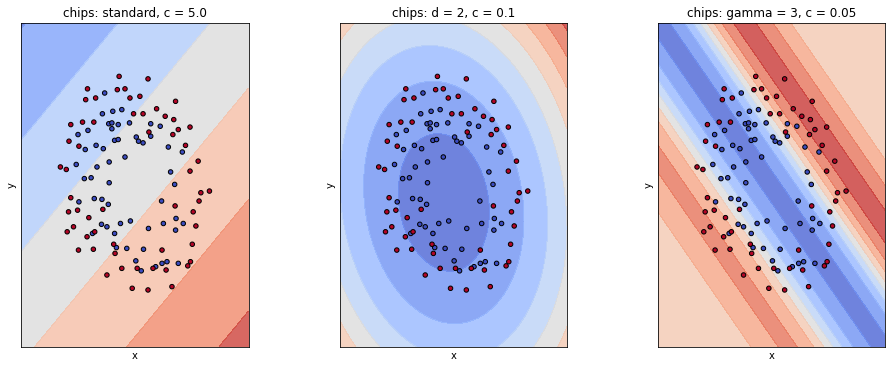

In [4]:
from functools import reduce
from operator import mul
from tqdm.notebook import tqdm

(dataset_name, (objects, results)) = datasets[0]

X0, X1 = objects[:, 0], objects[:, 1]
h = 0.05
total = 3 * len(results) * reduce(mul, np.meshgrid(np.arange(X0.min() - 0.5, X0.max() + 0.5, h), np.arange(X1.min() - 0.5, X1.max() + 0.5, h))[0].shape)
pbar = tqdm(total=total)

add_graphic(objects, results, dataset_name, kernels["linear"][0], 5.0, 0, pbar, h=h)
add_graphic(objects, results, dataset_name, kernels["polynomial"][0], 0.1, 1, pbar, h=h)
add_graphic(objects, results, dataset_name, kernels["gaussian"][2], 0.05, 2, pbar, h=h)

pbar.close()

show_plots()

### Geyser dataset

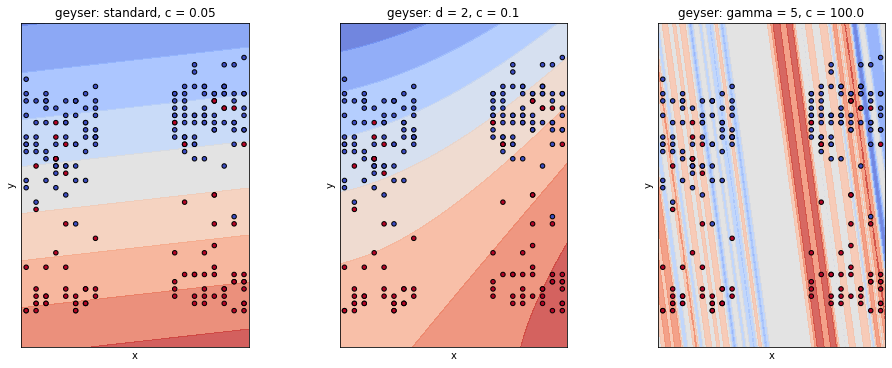

In [4]:
from functools import reduce
from operator import mul
from tqdm.notebook import tqdm

(dataset_name, (objects, results)) = datasets[1]

X0, X1 = objects[:, 0], objects[:, 1]
h = .08
total = 3 * len(results) * reduce(mul, np.meshgrid(np.arange(X0.min() - 0.5, X0.max() + 0.5, h), np.arange(X1.min() - 0.5, X1.max() + 0.5, h))[0].shape)
pbar = tqdm(total=total)

add_graphic(objects, results, dataset_name, kernels["linear"][0], 0.05, 0, pbar, h=h)
add_graphic(objects, results, dataset_name, kernels["polynomial"][0], 0.1, 1, pbar, h=h)
add_graphic(objects, results, dataset_name, kernels["gaussian"][4], 100.0, 2, pbar, h=h)

pbar.close()

show_plots()